## Robust Mean - Variance Portfolio Optimization

Robust portfolio optimization is a variant of traditional portfolio optimization. The objective is to allocate a total investment amount across different assets to maximize the portfolio's expected return, while ensuring a very low probability (e.g., 0.5%) that the actual return falls below this expected value. This approach addresses the uncertainty inherent in portfolio returns, making it a robust optimization problem.

In the example taken from Bertsimas and Den Hertog (2015) [1], Section 3.4, we have n = 200 assets. Let $r_i$ denote the return of the $i$-th asset. The return on Asset #200 $r_{n}=1.05$ has zero variability. The returns of the remaining assets $r_i$, $\forall i \in [n - 1]$, are random variables taking values in the intervals $[\mu_i - \sigma_i ,\mu_i + \sigma_i  ]$. $\mu$ and $\sigma$ are defined as:

$$ \mu_i = 1.05 + \frac{0.3\left(n - i\right)}{n - 1} , \space \sigma_i = 0.05 + \frac{0.6\left(n - i\right)}{n - 1}, \space \forall i \in [n - 1] $$



To solve this problem, we first import the required packages and generate the data. 

In [1]:
import lropt
import cvxpy as cp
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)


In [2]:
N = 200
GUARANTEED_RETURN = 1.05
b2 = 0.3
b3 = 0.05
b4 = 0.6
P = 2

mu = np.zeros(N - 1)
for i in range(N - 1):
    mu_i = GUARANTEED_RETURN + b2 * (N - i) / (N- 1)
    mu[i] = mu_i  

sigma = np.zeros(N - 1)
for i in range(N - 1):
    sigma_i = b3 + b4 * (N - i) / (N - 1)
    sigma[i] = sigma_i 


The problem we want to solve is the uncertain linear optimization problem:

$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad \mu^T x + \sigma^T x + 1.05x_{n} \geq t , \\
& 1^T x= 1, \\
& x \geq 0
\end{aligned}
$$

$ x_i $ is the capital to be invested in asset $i$. The guarenteed yearly return is 1.05.



In this problem, the uncertain data are the retuns $r_i = \mu_i + \sigma_i z_i, i \in [199]$ where $z$ is a vector of independant random variables with zero mean varying in the segments $[-1, 1]$. The robust counterpart to the uncertain linear optimization problem is:


$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad (\mu + \sigma^T z)^Tx + 1.05x_{n} \geq t , \quad \forall z \in \mathcal{Z}, \\
& 1^Tx= 1, \\
& x \geq 0
\end{aligned}
$$

for a variety of uncertainty sets $ \mathcal{Z} $. 

In the following snippet, we solve this problem using  Ellipsoidal and Budget uncertainty sets and compare the results.


In [3]:
names = ['Ellipsoidal', 'Budget']
rho_values = np.linspace(0.1, 2.0, 10)  # Range of rho values

results = []

# Loop over rho values
for rho in rho_values:
    uncertainty_sets = [
        lropt.Ellipsoidal(rho=rho, a=np.diag(sigma), b=mu),
        lropt.Budget(rho1=rho, rho2=rho, b=mu, a=np.diag(sigma))
    ]
    
    for uc_index, uc in enumerate(uncertainty_sets):
        t = cp.Variable()
        x = cp.Variable(N, nonneg=True)
        z = lropt.UncertainParameter(N - 1, uncertainty_set=uc)

        # Defining constraints
        constraints = [
            z @ x[:(N-1)] + GUARANTEED_RETURN * x[-1] >= t,
            cp.sum(x) == 1
        ]

        objective = cp.Maximize(t)
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()

        optimal_allocation = x.value
        optimal_return = float(t.value)

        # Compute risk based on optimal allocation
        cov_matrix = np.diag(sigma ** 2)
        variance = np.dot(optimal_allocation[:(N-1)].T, np.dot(cov_matrix, optimal_allocation[:(N-1)]))
        risk = np.sqrt(variance)

        results.append({
            'rho': rho,
            'uncertainty_set': names[uc_index],
            'return': optimal_return,
            'risk': risk
        })

The following code creates a graph of the tradeoff curve of risk and return. This was created by simulating the risk and calculating the return using the optimal allocations given by the solution of the robust problem. It is calculated over a range of values of $\rho$.

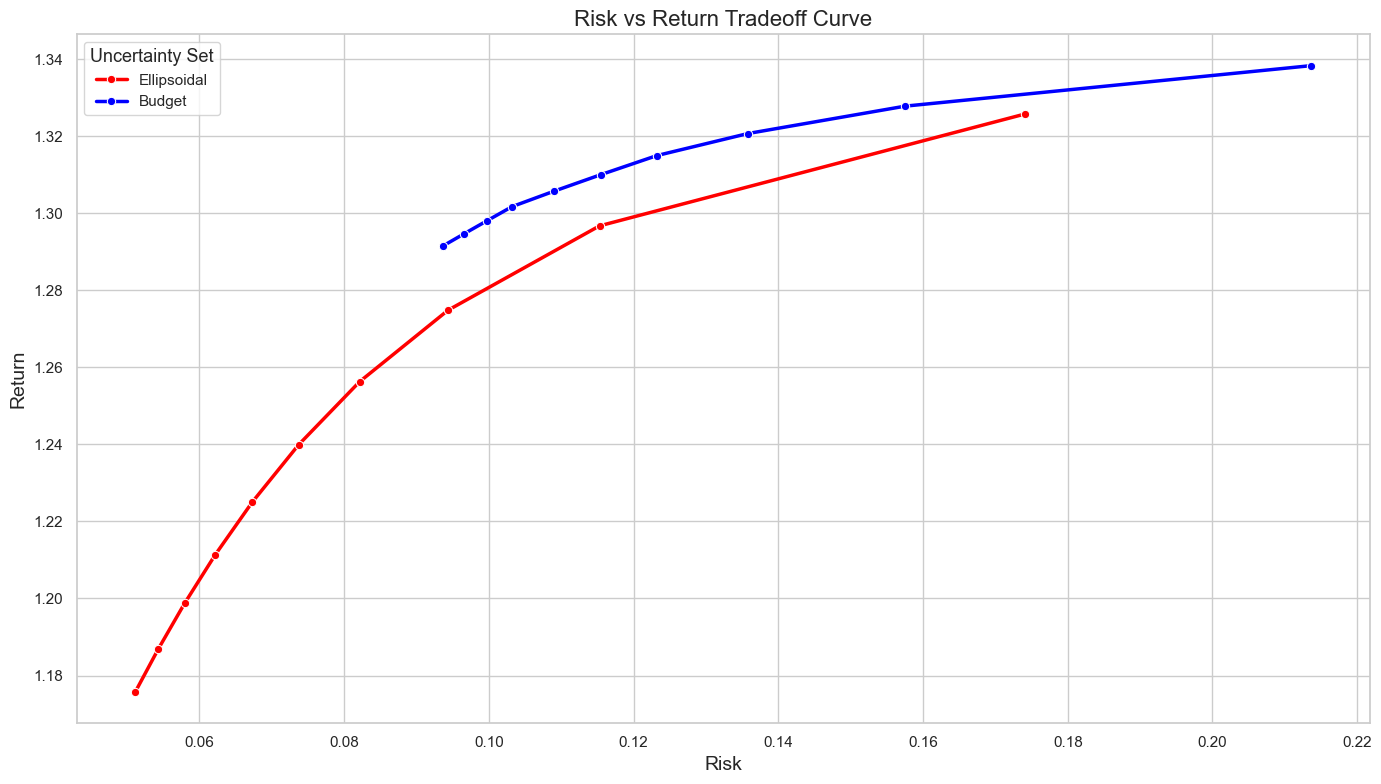

In [4]:
df_results = pd.DataFrame(results)

# Plotting the Risk vs Return tradeoff curve with Seaborn
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")
colors = ['red', 'blue']
# Create a color palette for the plot


# Plot with Seaborn
sns.lineplot(
    data=df_results,
    x='risk',
    y='return',
    hue='uncertainty_set',
    palette=colors,
    marker='o',
    linewidth=2.5
)

# Enhancing the plot
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Risk vs Return Tradeoff Curve', fontsize=16)
plt.legend(title='Uncertainty Set', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.